# House Prices - Advanced Regression Techniques

## Introduction

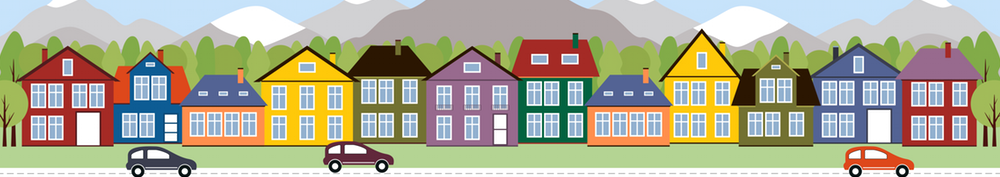

Bạn là một nhà môi giới bất động sản. Để có thể làm tốt công việc của mình, bạn yêu cầu khách hàng mua nhà mô tả ngôi nhà mơ ước của họ, và những tiêu chí họ nghĩ đến đầu tiên không phải căn nhà có tầng hầm hoặc vị trí nhà gần đường sắt. 

Với 79 biến giải thích, (gần như) mọi khía cạnh của nhà ở ở Ames, Iowa (2 thành phố của Mỹ). Cuộc thi này thách thức bạn dự đoán giá cuối cùng của mỗi ngôi nhà.

## Level 4

- Thách thức Feature Engineering.

- Đòi hỏi sử dụng các kỹ thuật Hồi quy nâng cao như Random forest hay Gradient boosting.

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [230]:
df_train = pd.read_csv('C:/Users/84909/Linear Regression/Datasets/train.csv')

In [231]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Descriptive statistics

### Tìm hiểu biến mục tiêu

In [232]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Ta có thể nhận xét một số thứ như sau:

- Min: Không có giá trị âm.

- Max: Giá trị max cách khá xa IQR3 (75%) nên ta nghi ngờ sẽ có outlier trong cột này.

Để làm rõ điều này, ta có thể vẽ một số biểu đồ để lấy thêm thông tin

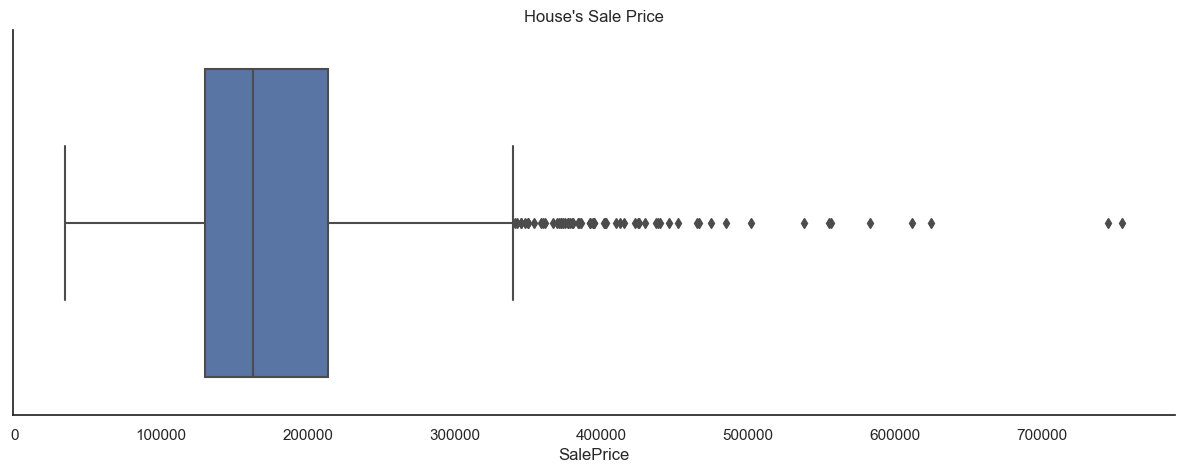

In [233]:
plt.figure(figsize=(15, 5))
sns.set(style="white")
sns.boxplot(data = df_train, x = 'SalePrice')
plt.title('House\'s Sale Price')
plt.yticks([])
sns.despine(top=True, right=True)
plt.show()

Biểu đồ boxplot cho chúng ta thấy được bức tranh tổng quan về các chỉ số như:

- Trung bình

- Độ lệch : Phần bên trên rộng hơn nên có thể nói cột SalePrice bị lệch phải.

- Outlier : Có khá nhiều outlier, hầu hết đều lớn hơn hẳn so với mức trung bình.

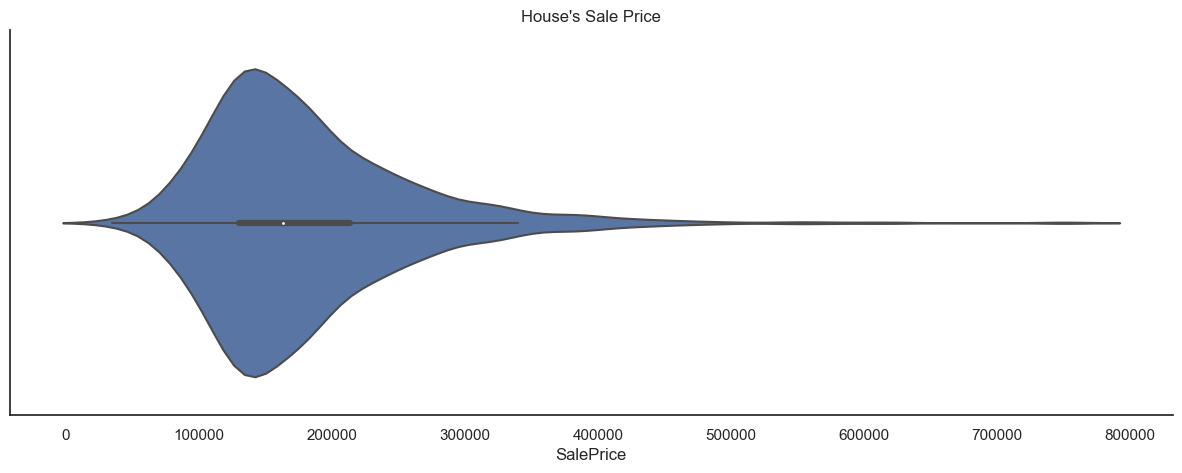

In [234]:
plt.figure(figsize=(15, 5))
sns.set(style="white")
sns.violinplot(data = df_train, x = 'SalePrice')
plt.title('House\'s Sale Price')
plt.yticks([])
sns.despine(top=True, right=True)
plt.show()

Có thể sử dụng biểu đồ này thay cho Histogram để thấy được phân phối của dữ liệu. (Ngoài ra sẽ thích hợp hơn khi kết hợp với các cột categories khác)

Ví dụ như:

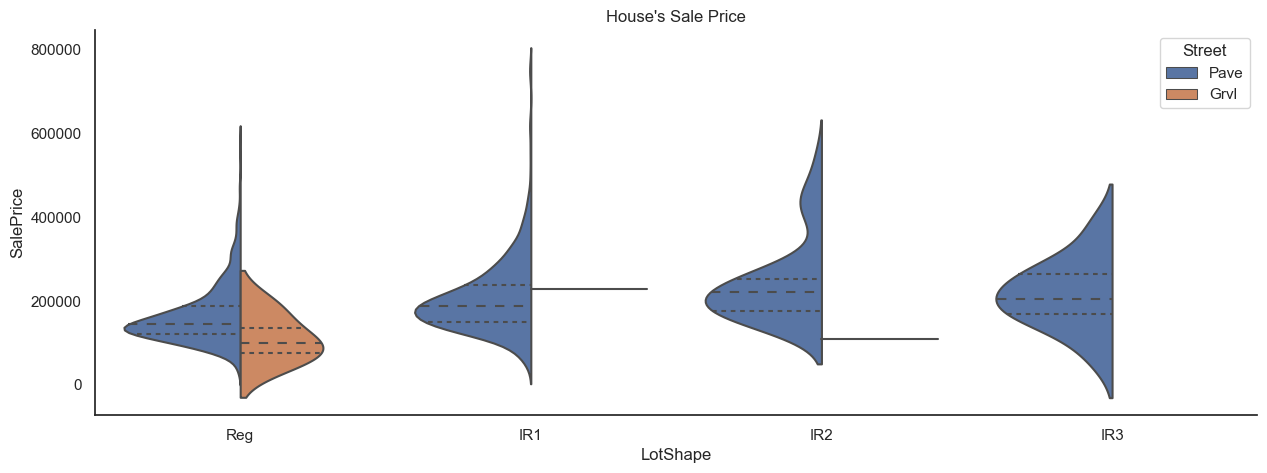

In [235]:
plt.figure(figsize=(15, 5))
sns.set(style="white")
sns.violinplot(data = df_train, x = 'LotShape', y = 'SalePrice', 
               hue = 'Street', split=True, inner="quart")
plt.title('House\'s Sale Price')
sns.despine(top=True, right=True)
plt.show()

Ta có thể nhận xét được:

- Đường trải sỏi (Grvl) phần lớn chỉ có ở những khu đất có hình dạng đều đặn (Reg), có rất ít ở những lô đất không đều (IR1 và IR2) và không có nếu lô đất rất không đều (IR3)

- Giá của những căn nhà có đường trải sỏi sẽ thấp và ổn định hơn so với đường trải nhựa qua hình dạng phân phối chuẩn hơn và không có outlier.

> Kiểu như nếu bạn là khách hàng, không quá quan trọng đường trải nhựa hay không thì giá nên cân nhắc mua những căn nhà có đường trải sỏi để thấp hơn. Hoặc là 1 bài toán trade-off giữa tiền mua căn nhà có đường trải nhựa và căn nhà đường trải sỏi sau đó thuê công nhân trải nhựa.

- LotShape xấu + Street cũng xấu thì trung bình của Grvl theo Reg và IR2 thấp hơn thì đúng rồi. Tuy nhiên ở IR1, Grvl lại cao hơn hẳn trung bình và gần bằng IQ3 của Pave. Ta có thể tìm ra căn nhà đặc biệt này.

In [236]:
df_train[(df_train.LotShape == 'IR1') & (df_train.Street == 'Grvl')]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950


Tạm thời ta sẽ bỏ qua căn nhà này để tiến hành các phân tích phía sau và sẽ quay lại nếu có thời gian.

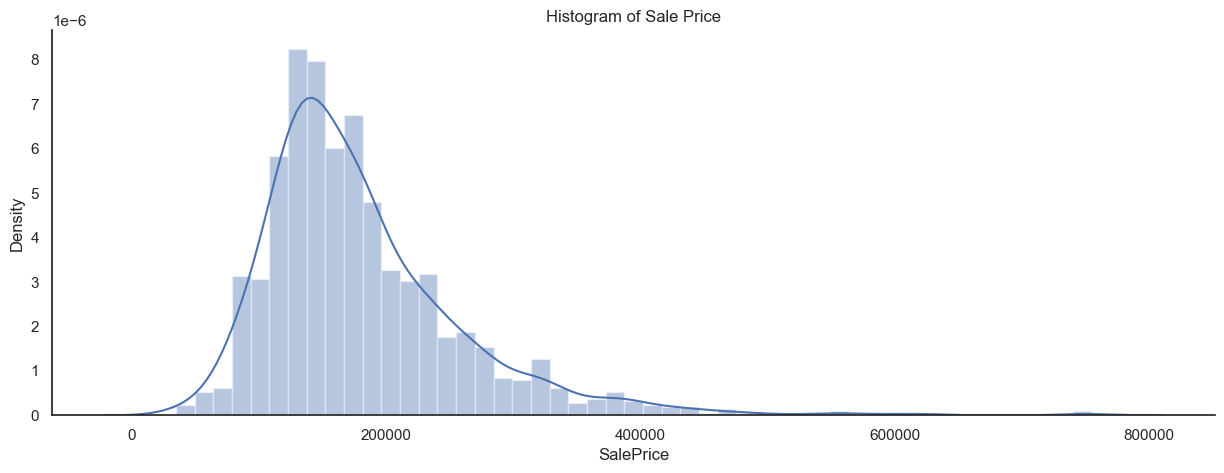

In [237]:
#histogram
plt.figure(figsize=(15, 5))
sns.set(style="white")
sns.distplot(df_train['SalePrice'])
plt.title('Histogram of Sale Price')
sns.despine(top=True, right=True)
plt.show()

- Hình dạng gần giống với phân phối chuẩn

- Bị lệch phải

Nói chung về độ lệch, chúng ta có một số độ đo moment để thể hiện độ lệch:

In [238]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


- Skewness > 0 : positive skewness cho thấy biểu đồ lệch phải đúng với các nhận xét phía trên.

- Kurtosis > 3 : cho thấy số lượng outlier khá lớn, hay nói cách khác xác suất xuất hiện outlier khá cao.

### Các biến khác

In [239]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Có khá nhiều cột bị missing value, để thể hiện tốt hơn ta cần dùng các hàm khác bên ngoài

In [257]:
missing_count = df_train.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_count / len(df)) * 100

In [258]:
missing_df = pd.DataFrame(missing_percentage[missing_percentage > 0]).reset_index()
missing_df.columns = ['Column', 'MissingPercentage']

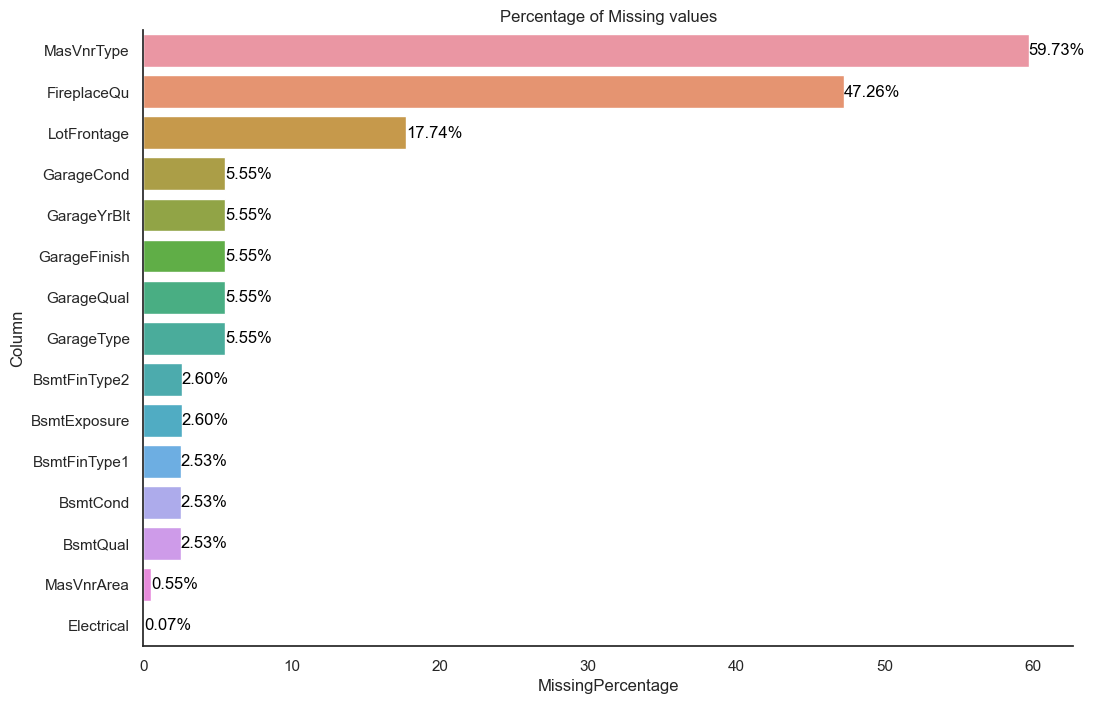

In [259]:
plt.figure(figsize=(12, 8))
sns.barplot(x='MissingPercentage', y='Column', data=missing_df)
for index, value in enumerate(missing_df['MissingPercentage']):
    plt.text(value, index, f'{value:.2f}%', color='black', va="center")
plt.title('Percentage of Missing values')
sns.despine(top=True, right=True)
plt.show()

Ta cần lưu ý một số điều quan trọng khi loại bỏ các cột missing data sau đây:

- THÔNG THƯỜNG nếu missing quá 70%-80% ta có thể loại bỏ cột đó.

Trong bài toán này, các cột missing value quá nhiều, tác giả ref nói rằng điều này cho thấy các biến này không quan trọng. Nghĩa là thông thường mọi người sẽ không đưa các biến nào vào xem xét để quyết định xem có nên mua một ngôi nhà hay không. Và chính chúng gây ra hiện tượng outliers (làm giá nhà tăng đột biến).

Chúng ta không làm bài toán detect outlier mà chúng ta chỉ muốn dự đoán pattern tổng quát. Do đó nên loại bỏ các biến này.

Tuy nhiên nếu bài toán đổi thành dự đoán chỉ số sức khỏe của một người để xem người đó có nguy cơ mắc bệnh ung thư hay không thì ta thật sự cần xem xét kỹ lưỡng khi loại bỏ các cột có missing value cao (chẳng hạn như bệnh nhân có hút thuốc lá chỉ chiếm 5% và những người này có nguy cơ ung thư cao).

In [255]:
df_train = df_train.drop(missing_df[missing_df['MissingPercentage'] > 80].Column, axis = 1)

Các biến liên quan đến Garage và Bsmt có cùng độ missing value. Do đó ta có thể nghi ngờ những records này giống nhau, nên sẽ loại bỏ các 

In [206]:
category_df = df_train.select_dtypes(include=['object'])
numeric_df = df_train.select_dtypes(include=['number'])

Ta kiểm tra xem có biến nào là category nhưng bị missing value:

In [217]:
category_df[missing_df.Column]

KeyError: "None of [Index(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'], dtype='object')] are in the [columns]"

In [211]:
temp = ['MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'Electrical']

In [212]:
df_train[temp] = df_train[temp].fillna(value = 'None')

Còn lại là những cột numeric bị missing value, ta sẽ dùng cách khác để điền vào các giá trị còn thiếu này.

In [ ]:
temp = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

In [ ]:
corrmat = numeric_df.corr()
sns.heatmap(corrmat, annot=True, fmt='.2f', cmap='coolwarm')

<Axes: >

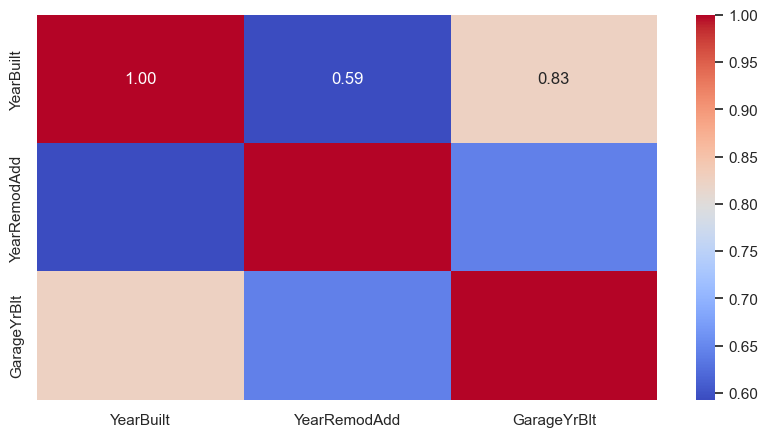

In [224]:
plt.figure(figsize=(10, 5))
temp2 = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
sns.heatmap(df_train[temp2].corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [226]:
df_train[df_train.YearBuilt == df_train.GarageYrBlt].shape

(1089, 81)

In [228]:
df_train[(df_train.YearRemodAdd == df_train.GarageYrBlt) & (df_train.YearBuilt != df_train.YearRemodAdd)].shape

(54, 81)

## Pre-processing

In [197]:
df_train.PoolQC = df_train.PoolQC.fillna(value = 'None')
df_train.MiscFeature = df_train.MiscFeature.fillna(value = 'None')
df_train.Alley = df_train.Alley.fillna(value = 'None')
df_train.Fence = df_train.Fence.fillna(value = 'None')


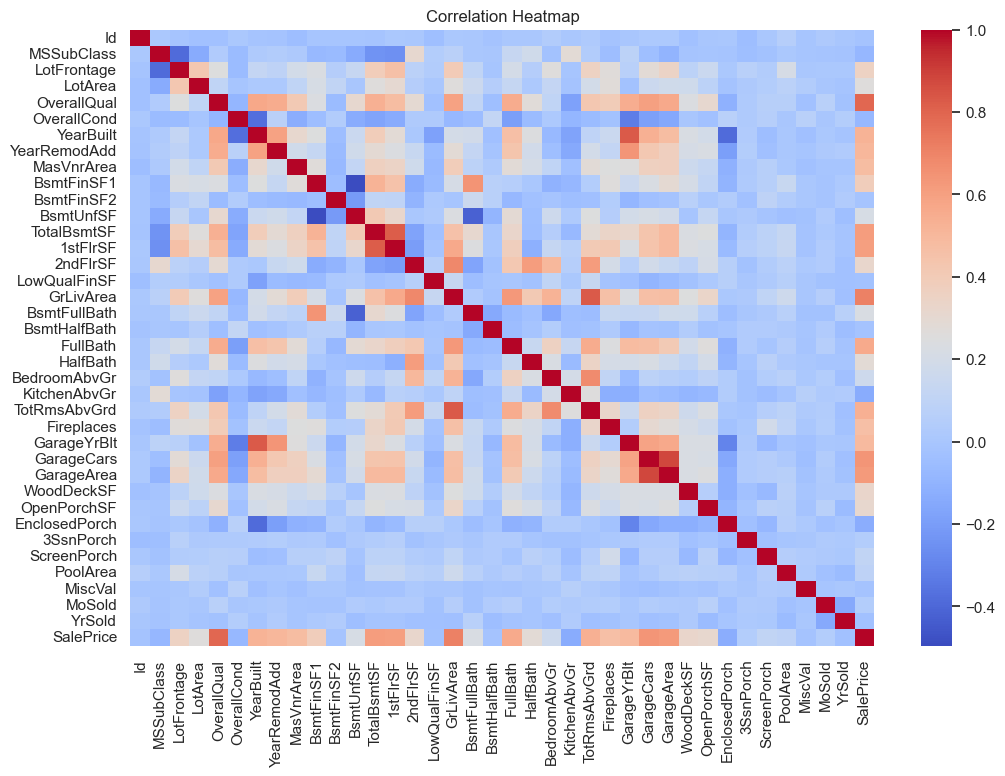

In [245]:
plt.figure(figsize=(12, 8))
sns.heatmap(corrmat, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()